# **Configuração de ambiente e carregamento dos dados**

In [ ]:
# Instalar MLFlow e ngrok
!pip install mlflow
!pip install pyngrok
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from pyngrok import ngrok

## **Carregamento do Conjuto de Dados:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Baixamos os dados do primeiro projeto que mergirmos a partir das informações presentes na tabela de resultados(`df_full`) e da tabela de estatísticas(`df_estatisticas`)

In [ ]:
# Caminho para o arquivo CSV no Google Drive
caminho_arquivo = '/content/drive/My Drive/dados/df_proj2.csv'

# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv(caminho_arquivo)

Como sabemos pela primeira parte do projeto, os dados até 2018 os dados não estão totalmente completos para fazer um modelo de previsão iremos usar os dados apenas apartir de 2018 e para os poucos dados faltando iremos fazer uma simples imputação de dados usando a interpolação com método 'spearman'

In [ ]:
# Trocar o valor 3 pelo valor 2 na coluna 'vencedor'
df['vencedor'] = df['vencedor'].replace(3, 2)

Agora, a coluna vencedor possui 3 classes: 0 para derrota, 1 para empate, 2 para vitória

#### Selecionando apenas os dados após 2018

In [ ]:
# Filtrando os dados após 2018
df_pos_2018 = df[df['ano'] > 2017]

df_pos_2018.head()

,ID,ano,rodada,clube,vencedor,gols_marcados,gols_recebidos,chutes,chutes_a_gol,posse_de_bola,passes,precisao_dos_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios,mandante
12250,6126,2018,1,Cruzeiro,0,0,1,12,2,0.40,425,0.81,20,3,0,0,7,1
12251,6126,2018,1,Gremio,2,1,0,6,2,0.60,649,0.86,15,1,1,3,4,0
12252,6127,2018,1,Vitoria,1,2,2,21,6,0.66,545,0.88,24,3,0,2,4,1
12253,6127,2018,1,Flamengo,1,2,2,10,5,0.34,286,0.72,10,2,1,2,5,0
12254,6128,2018,1,Santos,2,2,0,22,3,0.54,532,0.90,7,0,0,1,4,1


In [ ]:
# Filtrando os dados após 2018
df_pos_2018 = df[df['ano'] >= 2018].copy()

# Imputação de valores ausentes para 'posse_de_bola' e 'precisao_dos_passes' usando interpolação com método 'linear'
df_pos_2018.loc[:, 'posse_de_bola'] = df_pos_2018['posse_de_bola'].interpolate(method='linear')
df_pos_2018.loc[:, 'precisao_dos_passes'] = df_pos_2018['precisao_dos_passes'].interpolate(method='linear')

# Atualizando o dataframe original com os valores imputados
df_pos_2018.update(df_pos_2018)

In [ ]:
df_pos_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4560 entries, 12250 to 16809
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   4560 non-null   int64  
 1   ano                  4560 non-null   int64  
 2   rodada               4560 non-null   int64  
 3   clube                4560 non-null   object 
 4   vencedor             4560 non-null   int64  
 5   gols_marcados        4560 non-null   int64  
 6   gols_recebidos       4560 non-null   int64  
 7   chutes               4560 non-null   int64  
 8   chutes_a_gol         4560 non-null   int64  
 9   posse_de_bola        4560 non-null   float64
 10  passes               4560 non-null   int64  
 11  precisao_dos_passes  4560 non-null   float64
 12  faltas               4560 non-null   int64  
 13  cartao_amarelo       4560 non-null   int64  
 14  cartao_vermelho      4560 non-null   int64  
 15  impedimentos         4560 non-null   i

#### Normalizando os dados

In [ ]:
# Selecionar as colunas que serão normalizadas
colunas_normalizacao = ['posse_de_bola', 'chutes', 'passes', 'chutes_a_gol',
                        'faltas', 'cartao_amarelo', 'cartao_vermelho',
                        'impedimentos', 'escanteios', 'precisao_dos_passes']

# Criar um MinMaxScaler e um StandardScaler
scaler_minmax = MinMaxScaler()

# Normalização Min-Max
df_estatisticas = df_pos_2018.copy()
df_estatisticas[colunas_normalizacao] = scaler_minmax.fit_transform(df_estatisticas[colunas_normalizacao])

In [ ]:
df_estatisticas.tail()

,ID,ano,rodada,clube,vencedor,gols_marcados,gols_recebidos,chutes,chutes_a_gol,posse_de_bola,passes,precisao_dos_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios,mandante
16805,8403,2023,38,Santos,0,1,2,0.405405,0.333333,0.583333,0.416274,0.703704,0.483871,0.2,0.000000,0.444444,0.434783,1
16806,8404,2023,38,Sao Paulo,2,1,0,0.243243,0.166667,0.366667,0.478774,0.833333,0.419355,0.0,0.000000,0.222222,0.173913,1
16807,8404,2023,38,Flamengo,0,0,1,0.270270,0.111111,0.633333,0.630896,0.925926,0.516129,0.3,0.000000,0.000000,0.391304,0
16808,8405,2023,38,Vasco,2,2,1,0.351351,0.333333,0.416667,0.378538,0.722222,0.258065,0.3,0.000000,0.000000,0.086957,1
16809,8405,2023,38,Bragantino,0,1,2,0.243243,0.111111,0.583333,0.469340,0.759259,0.451613,0.1,0.333333,0.111111,0.130435,0


# **1. Escolha da coluna para classificação**

O problema que escolhemos resolver nesse projeto, foi o de tentar classificar o resultado da partida a partir das estatísticas dela. Sendo assim, o problema se trata da classificação da coluna "vencedor"

# **2. Divisão dos dados**

60% treinamento; 20% validação; 20% teste

In [ ]:
from sklearn.model_selection import train_test_split

# Definir as variáveis independentes (X) e a variável dependente (y)
X = df_estatisticas.drop(columns=['vencedor', 'clube', 'ID', 'ano', 'rodada'])
y = df_estatisticas['vencedor']

# Separar os dados em treinamento e conjunto temporário (validação + teste)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Separar o conjunto temporário em validação e teste
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Verificar o tamanho de cada conjunto
print(f'Tamanho do conjunto de treinamento: {X_train.shape[0]}')
print(f'Tamanho do conjunto de validação: {X_val.shape[0]}')
print(f'Tamanho do conjunto de teste: {X_test.shape[0]}')

Tamanho do conjunto de treinamento: 2736
Tamanho do conjunto de validação: 912
Tamanho do conjunto de teste: 912


In [ ]:
X.head()

,gols_marcados,gols_recebidos,chutes,chutes_a_gol,posse_de_bola,passes,precisao_dos_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios,mandante
12250,0,1,0.324324,0.111111,0.333333,0.501179,0.777778,0.645161,0.3,0.000000,0.000000,0.304348,1
12251,1,0,0.162162,0.111111,0.666667,0.765330,0.870370,0.483871,0.1,0.333333,0.333333,0.173913,0
12252,2,2,0.567568,0.333333,0.766667,0.642689,0.907407,0.774194,0.3,0.000000,0.222222,0.173913,1
12253,2,2,0.270270,0.277778,0.233333,0.337264,0.611111,0.322581,0.2,0.333333,0.222222,0.217391,0
12254,2,0,0.594595,0.166667,0.566667,0.627358,0.944444,0.225806,0.0,0.000000,0.111111,0.173913,1


In [ ]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

vencedor
2    987
0    987
1    762
Name: count, dtype: int64
vencedor
2    329
0    329
1    254
Name: count, dtype: int64
vencedor
2    329
0    329
1    254
Name: count, dtype: int64


# **3. Seleção dos 4 algoritmos**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Definir os algoritmos e seus hiperparâmetros básicos
algorithms = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, random_state=42),
    'SVM': Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='linear', probability=True, random_state=42))])
}

# Treinar e avaliar cada algoritmo
for name, model in algorithms.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"Resultados do {name}:")
    print(classification_report(y_val, y_pred))

    # Validacao cruzada
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name}: {scores.mean()} (+/- {scores.std() * 2})")

Resultados do Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       329
           1       0.99      0.98      0.99       254
           2       0.99      1.00      0.99       329

    accuracy                           0.99       912
   macro avg       0.99      0.99      0.99       912
weighted avg       0.99      0.99      0.99       912

Random Forest: 0.9937856122980024 (+/- 0.007530613393875342)
Resultados do XGBoost:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       329
           1       1.00      0.99      1.00       254
           2       1.00      0.99      1.00       329

    accuracy                           1.00       912
   macro avg       1.00      1.00      1.00       912
weighted avg       1.00      1.00      1.00       912

XGBoost: 0.9996350364963504 (+/- 0.0014598540145985162)
Resultados do Logistic Regression:
              precision    recall 

### Removendo as colunas de gols marcados e sofridos

Percebemos que os algoritmos estão tendo uma avaliação muito boa. Muito provavelmente isso está acontecendo pois as colunas de gols marcados e sofridos pelo time na partida estão deixando muito óbvio o resultado da partida.<br>
Sendo assim, decidimos remover essas duas colunas do dataset, e os modelos deveram prever o resultado da partida apenas com as outras estatísticas da partida.

In [ ]:
# Definir as variáveis independentes (X) e a variável dependente (y)
X = df_estatisticas.drop(columns=['vencedor', 'clube', 'ID', 'ano', 'rodada', 'gols_marcados', 'gols_recebidos'])
y = df_estatisticas['vencedor']

# Separar os dados em treinamento e conjunto temporário (validação + teste)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Separar o conjunto temporário em validação e teste
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Treinar e avaliar cada algoritmo
for name, model in algorithms.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"Resultados do {name}:")
    print(classification_report(y_val, y_pred))

    # Validacao cruzada
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name}: {scores.mean()} (+/- {scores.std() * 2})")

Resultados do Random Forest:
              precision    recall  f1-score   support

           0       0.54      0.60      0.57       329
           1       0.34      0.20      0.25       254
           2       0.56      0.67      0.61       329

    accuracy                           0.52       912
   macro avg       0.48      0.49      0.48       912
weighted avg       0.49      0.52      0.50       912

Random Forest: 0.5215568662512176 (+/- 0.034019821333218486)
Resultados do XGBoost:
              precision    recall  f1-score   support

           0       0.51      0.56      0.53       329
           1       0.34      0.24      0.28       254
           2       0.52      0.58      0.55       329

    accuracy                           0.48       912
   macro avg       0.46      0.46      0.46       912
weighted avg       0.47      0.48      0.47       912

XGBoost: 0.49377693857670907 (+/- 0.03268755833687539)
Resultados do Logistic Regression:
              precision    recall  

Agora, sem as informações de gols marcados e sofridos, a avaliação dos modelos caiu dastricamente.<br>
Sendo assim, vamos procurar meios para melhorar a avaliação dos modelos para alcançar uma acurácia satisfatória

### Juntando a partida numa mesma linha

Para tentar melhorar o desempenho do modelo, juntarei os dados de uma mesma partida, que atualmente está dividida em duas linhas do df, em uma única linha, de modo que o modelo tenha as estatísticas completas da partida por instância (estatísticas tanto do time mandante quanto do visitante)

In [ ]:
# Separar mandantes e visitantes
mandantes = df_estatisticas[df_estatisticas['mandante'] == 1].copy()
visitantes = df_estatisticas[df_estatisticas['mandante'] == 0].copy()

# Renomear colunas (excluindo 'ID' e 'tipo')
mandantes.columns = ['ID'] + ['mandante_' + col for col in mandantes.columns if col not in ['ID', 'tipo']]
visitantes.columns = ['ID'] + ['visitante_' + col for col in visitantes.columns if col not in ['ID', 'tipo']]

# Mesclar as tabelas
df_unificado = pd.merge(mandantes, visitantes, on='ID')

# Verificar o resultado
df_unificado.head()

,ID,mandante_ano,mandante_rodada,mandante_clube,mandante_vencedor,mandante_gols_marcados,mandante_gols_recebidos,mandante_chutes,mandante_chutes_a_gol,mandante_posse_de_bola,...,visitante_chutes_a_gol,visitante_posse_de_bola,visitante_passes,visitante_precisao_dos_passes,visitante_faltas,visitante_cartao_amarelo,visitante_cartao_vermelho,visitante_impedimentos,visitante_escanteios,visitante_mandante
0,6126,2018,1,Cruzeiro,0,0,1,0.324324,0.111111,0.333333,...,0.111111,0.666667,0.765330,0.870370,0.483871,0.1,0.333333,0.333333,0.173913,0
1,6127,2018,1,Vitoria,1,2,2,0.567568,0.333333,0.766667,...,0.277778,0.233333,0.337264,0.611111,0.322581,0.2,0.333333,0.222222,0.217391,0
2,6128,2018,1,Santos,2,2,0,0.594595,0.166667,0.566667,...,0.111111,0.433333,0.556604,0.851852,0.161290,0.1,0.000000,0.000000,0.086957,0
3,6129,2018,1,America-MG,2,3,0,0.378378,0.222222,0.300000,...,0.277778,0.700000,0.683962,0.851852,0.387097,0.3,0.000000,0.333333,0.260870,0
4,6130,2018,1,Vasco,2,2,1,0.513514,0.388889,0.783333,...,0.333333,0.216667,0.378538,0.722222,0.580645,0.3,0.000000,0.333333,0.130435,0


In [ ]:
df_unificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2280 entries, 0 to 2279
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             2280 non-null   int64  
 1   mandante_ano                   2280 non-null   int64  
 2   mandante_rodada                2280 non-null   int64  
 3   mandante_clube                 2280 non-null   object 
 4   mandante_vencedor              2280 non-null   int64  
 5   mandante_gols_marcados         2280 non-null   int64  
 6   mandante_gols_recebidos        2280 non-null   int64  
 7   mandante_chutes                2280 non-null   float64
 8   mandante_chutes_a_gol          2280 non-null   float64
 9   mandante_posse_de_bola         2280 non-null   float64
 10  mandante_passes                2280 non-null   float64
 11  mandante_precisao_dos_passes   2280 non-null   float64
 12  mandante_faltas                2280 non-null   f

Criando uma nova colunas 'vencedor' mais adequada pra esse caso, e removendo colunas desnecessárias.<br>
A coluna vencedor receberá os seguintes valores: 1 caso o mandante venceu, 2 se o visitante venceu, e 0 caso tenha sido empate

In [ ]:
# Supondo que df_unificado é o DataFrame resultante da união
def determinar_vencedor(row):
    if row['mandante_gols_marcados'] > row['visitante_gols_marcados']:
        return 1
    elif row['mandante_gols_marcados'] < row['visitante_gols_marcados']:
        return 2
    else:
        return 0

# Aplicar a função para criar a coluna 'vencedor'
df_unificado['vencedor'] = df_unificado.apply(determinar_vencedor, axis=1)

# Verificar o resultado
df_unificado.head()

,ID,mandante_ano,mandante_rodada,mandante_clube,mandante_vencedor,mandante_gols_marcados,mandante_gols_recebidos,mandante_chutes,mandante_chutes_a_gol,mandante_posse_de_bola,...,visitante_posse_de_bola,visitante_passes,visitante_precisao_dos_passes,visitante_faltas,visitante_cartao_amarelo,visitante_cartao_vermelho,visitante_impedimentos,visitante_escanteios,visitante_mandante,vencedor
0,6126,2018,1,Cruzeiro,0,0,1,0.324324,0.111111,0.333333,...,0.666667,0.765330,0.870370,0.483871,0.1,0.333333,0.333333,0.173913,0,2
1,6127,2018,1,Vitoria,1,2,2,0.567568,0.333333,0.766667,...,0.233333,0.337264,0.611111,0.322581,0.2,0.333333,0.222222,0.217391,0,0
2,6128,2018,1,Santos,2,2,0,0.594595,0.166667,0.566667,...,0.433333,0.556604,0.851852,0.161290,0.1,0.000000,0.000000,0.086957,0,1
3,6129,2018,1,America-MG,2,3,0,0.378378,0.222222,0.300000,...,0.700000,0.683962,0.851852,0.387097,0.3,0.000000,0.333333,0.260870,0,1
4,6130,2018,1,Vasco,2,2,1,0.513514,0.388889,0.783333,...,0.216667,0.378538,0.722222,0.580645,0.3,0.000000,0.333333,0.130435,0,1


#### Redividindo os dados para a nova configuração do dataset

In [ ]:
# Definir as variáveis independentes (X) e a variável dependente (y)
X = df_unificado.drop(columns=['vencedor', 'mandante_vencedor', 'visitante_vencedor', 'mandante_clube', 'visitante_clube', 'ID', 'mandante_ano', 'visitante_ano', 'mandante_rodada', 'visitante_rodada', 'mandante_gols_marcados', 'mandante_gols_recebidos', 'visitante_gols_marcados', 'visitante_gols_recebidos', 'mandante_mandante', 'visitante_mandante'])
y = df_unificado['vencedor']

# Separar os dados em treinamento e conjunto temporário (validação + teste)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Separar o conjunto temporário em validação e teste
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
# Treinar e avaliar cada algoritmo
for name, model in algorithms.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"Resultados do {name}:")
    print(classification_report(y_val, y_pred))

    # Validacao cruzada
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name}: {scores.mean()} (+/- {scores.std() * 2})")

Resultados do Random Forest:
              precision    recall  f1-score   support

           0       0.36      0.22      0.27       127
           1       0.61      0.81      0.70       215
           2       0.54      0.43      0.48       114

    accuracy                           0.55       456
   macro avg       0.50      0.49      0.48       456
weighted avg       0.52      0.55      0.52       456

Random Forest: 0.5314403358198978 (+/- 0.04691187209701502)
Resultados do XGBoost:
              precision    recall  f1-score   support

           0       0.34      0.29      0.31       127
           1       0.62      0.70      0.66       215
           2       0.51      0.47      0.49       114

    accuracy                           0.53       456
   macro avg       0.49      0.49      0.49       456
weighted avg       0.52      0.53      0.52       456

XGBoost: 0.5204646934573941 (+/- 0.007786288391823079)
Resultados do Logistic Regression:
              precision    recall  f

Percebemos então que com a junção dos dados das partidas em uma única linha ocasionou em uma pequena melhora na avaliação de cada modelo.<br>
Ainda assim, essa melhora não foi suficiente para tornar a acurácia dos modelos satisfatória...

# **4 e 5. Adicionando MLFlow e seletor de hiper-parâmetros**

In [ ]:
!ngrok authtoken 2j1cUyLEI6Y4QrEza8GSP7G9FSK_66ciVbRdQxX5ZidPqoAvk

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import subprocess
from pyngrok import ngrok, conf
import mlflow

ngrok.set_auth_token("2j1cUyLEI6Y4QrEza8GSP7G9FSK_66ciVbRdQxX5ZidPqoAvk")

# Iniciar o MLFlow em um subprocesso
process = subprocess.Popen(['mlflow', 'ui', '--port', '5000'])

# Criar um túnel para a porta 5000
tunnel = ngrok.connect(5000, "http")
url = tunnel.public_url
print(f'Access the MLflow UI at: {url}')

# Configurar o experimento no MLFlow
mlflow.set_experiment("Classificação Futebol")


Access the MLflow UI at: https://d8a1-34-73-20-44.ngrok-free.app


<Experiment: artifact_location='file:///content/mlruns/937210983275880471', creation_time=1720702797477, experiment_id='937210983275880471', last_update_time=1720702797477, lifecycle_stage='active', name='Classificação Futebol', tags={}>

Para o seletor de hiper-parâmetros, optamos pelo Grid Search

In [ ]:
# Configurar o experimento no MLFlow
mlflow.set_experiment("Classificação Futebol")

# Função para treinar e registrar modelos
def train_and_log_model(name, model, param_grid, X_train, y_train, X_val, y_val):
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_val)
    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1_score = report['weighted avg']['f1-score']

    with mlflow.start_run(run_name=name):
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1_score)
        mlflow.sklearn.log_model(best_model, "model")

    return best_model, accuracy, f1_score, grid_search.best_params_

# Definir os algoritmos e seus hiperparâmetros básicos
algorithms = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10, 20],
            'model__class_weight': [None, 'balanced']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        'param_grid': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1, 0.3],
            'model__max_depth': [3, 6, 9],
            'model__scale_pos_weight': [1, 2, 3]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, random_state=42),
        'param_grid': {
            'model__C': [0.1, 1, 10],
            'model__class_weight': [None, 'balanced']
        }
    },
    'SVM': {
        'model': SVC(kernel='linear', probability=True, random_state=42),
        'param_grid': {
            'model__C': [0.1, 1, 10],
            'model__class_weight': [None, 'balanced']
        }
    }
}

# Treinar e avaliar cada algoritmo com Grid Search e MLFlow
best_models = {}
for name, config in algorithms.items():
    model, accuracy, f1_score, best_params = train_and_log_model(name, config['model'], config['param_grid'], X_train, y_train, X_val, y_val)
    best_models[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1_score,
        'best_params': best_params
    }

# Selecionar o melhor modelo com base na acurácia
best_model_name = max(best_models, key=lambda name: best_models[name]['accuracy'])
best_model_info = best_models[best_model_name]

print(f"Melhor Modelo no conjunto de validação: {best_model_name}")
print(f"Acurácia no conjunto de validação: {best_model_info['accuracy']}")
print(f"F1-Score no conjunto de validação: {best_model_info['f1_score']}")
print(f"Hiperparâmetros do melhor modelo: {best_model_info['best_params']}")

# Avaliar o melhor modelo de cada algoritmo no conjunto de teste
for name, info in best_models.items():
    best_model = info['model']
    y_pred_test = best_model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    f1_score_test = classification_report(y_test, y_pred_test, output_dict=True)['weighted avg']['f1-score']
    info['accuracy_test'] = accuracy_test
    info['f1_score_test'] = f1_score_test
    #print(f"\nResultados do {name} no conjunto de teste:")
    #print(classification_report(y_test, y_pred_test))

# Selecionar o melhor modelo com base na métrica de avaliação (accuracy no conjunto de teste)
best_model_name = max(best_models, key=lambda name: best_models[name]['accuracy_test'])
best_model_info = best_models[best_model_name]

print(f"\nMelhor Modelo no conjunto de teste: {best_model_name}")
print(f"Hiperparâmetros do melhor modelo: {best_model_info['best_params']}")
print(f"Acurácia no conjunto de teste: {best_model_info['accuracy_test']}")
print(f"F1-Score no conjunto de teste: {best_model_info['f1_score_test']}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:19:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Melhor Modelo no conjunto de validação: Logistic Regression
Acurácia no conjunto de validação: 0.6030701754385965
F1-Score no conjunto de validação: 0.6003445119901893
Hiperparâmetros do melhor modelo: {'model__C': 0.1, 'model__class_weight': None}

Melhor Modelo no conjunto de teste: Logistic Regression
Hiperparâmetros do melhor modelo: {'model__C': 0.1, 'model__class_weight': None}
Acurácia no conjunto de teste: 0.5570175438596491
F1-Score no conjunto de teste: 0.5530847259175534


# **6. Diagnóstico e tentativa de aprimoração**

### Análise detalhada da performance do modelo

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

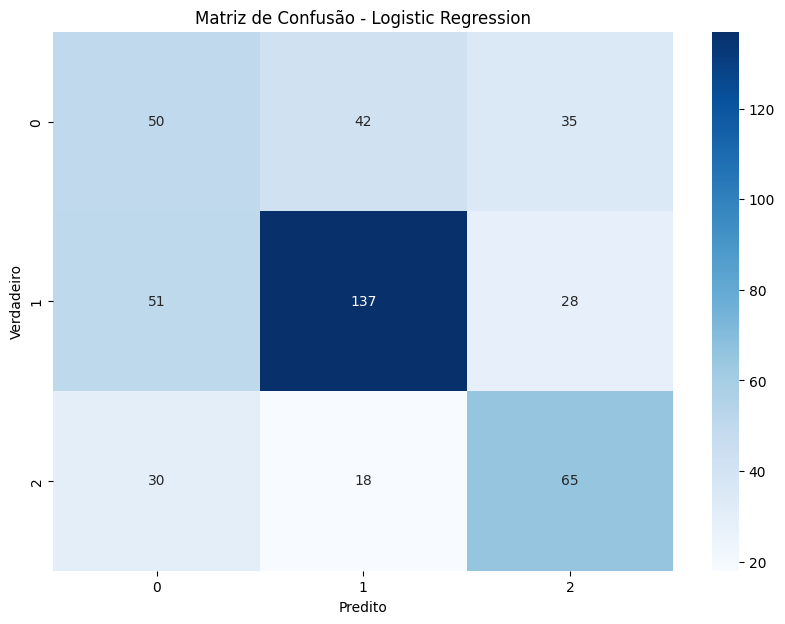

              precision    recall  f1-score   support

           0       0.38      0.39      0.39       127
           1       0.70      0.63      0.66       216
           2       0.51      0.58      0.54       113

    accuracy                           0.55       456
   macro avg       0.53      0.53      0.53       456
weighted avg       0.56      0.55      0.56       456



In [ ]:
y_pred_test = best_model.predict(X_test)

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Logistic Regression')
plt.show()

# Métricas detalhadas
print(classification_report(y_test, y_pred_test))

### Balanceamento de dados

In [ ]:
from collections import Counter

# Supondo que X_train, y_train, X_val, y_val, X_test, y_test já estejam definidos

# Contar instâncias no conjunto de treinamento
train_counter = Counter(y_train)
print(f"Distribuição das classes no conjunto de treinamento: {train_counter}")

# Contar instâncias no conjunto de validação
val_counter = Counter(y_val)
print(f"Distribuição das classes no conjunto de validação: {val_counter}")

# Contar instâncias no conjunto de teste
test_counter = Counter(y_test)
print(f"Distribuição das classes no conjunto de teste: {test_counter}")

Distribuição das classes no conjunto de treinamento: Counter({1: 646, 0: 381, 2: 341})
Distribuição das classes no conjunto de validação: Counter({1: 215, 0: 127, 2: 114})
Distribuição das classes no conjunto de teste: Counter({1: 216, 0: 127, 2: 113})


In [ ]:
from imblearn.over_sampling import RandomOverSampler
# Aplicar o RandomOverSampler ao conjunto de treinamento
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [ ]:
train_counter = Counter(y_train_resampled)
print(f"Distribuição das classes no conjunto de treinamento: {train_counter}")

Distribuição das classes no conjunto de treinamento: Counter({1: 646, 2: 646, 0: 646})


### Resultado

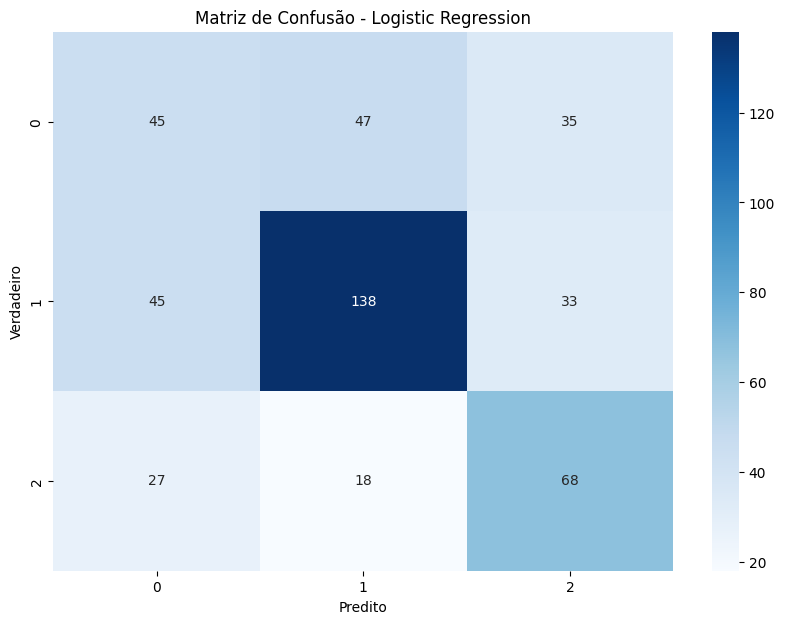

              precision    recall  f1-score   support

           0       0.38      0.35      0.37       127
           1       0.68      0.64      0.66       216
           2       0.50      0.60      0.55       113

    accuracy                           0.55       456
   macro avg       0.52      0.53      0.52       456
weighted avg       0.55      0.55      0.55       456



In [ ]:
best_model.fit(X_train_resampled, y_train_resampled)

y_pred_test = best_model.predict(X_test)

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title(f'Matriz de Confusão - Logistic Regression')
plt.show()

# Métricas detalhadas
print(classification_report(y_test, y_pred_test))

# **Conclusão**

Conclusão
Neste projeto, buscamos desenvolver um modelo de machine learning para prever o resultado de partidas de futebol utilizando dados estatísticos detalhados de jogos do Campeonato Brasileiro. Embora o modelo final, baseado em Regressão Logística, tenha alcançado uma acurácia de aproximadamente 55%, este resultado deve ser interpretado com a devida consideração das complexidades inerentes ao problema.

Prever o resultado de uma partida de futebol é um desafio significativo devido à natureza imprevisível do esporte. Diversos fatores imprevisíveis podem influenciar o desfecho de uma partida, como eventos aleatórios durante o jogo (lesões, decisões de arbitragem controversas, condições climáticas adversas), o estado emocional e físico dos jogadores, entre outros.

Além disso, uma análise das estatísticas das partidas revela um fenômeno comum no futebol: times que apresentam melhores números em aspectos como chutes e posse de bola nem sempre garantem a vitória. Por exemplo, um time pode adotar uma estratégia de contra-ataques, optando por uma postura mais defensiva e explorando os espaços deixados pelo adversário. Embora este time apresente estatísticas menores em posse de bola e número de chutes, pode ser eficaz ao marcar gols e, consequentemente, vencer ou empatar a partida.

Este comportamento estratégico sublinha a dificuldade de capturar todas as nuances do futebol em um modelo preditivo baseado exclusivamente em estatísticas de jogo. As estatísticas refletem apenas uma parte do cenário, e não conseguem capturar a totalidade das dinâmicas e das táticas empregadas pelos times.

Apesar da acurácia relativamente baixa, o desenvolvimento deste modelo representa um passo importante no entendimento das métricas e no aprimoramento das técnicas de predição. Para melhorias futuras, recomenda-se a incorporação de variáveis adicionais, como dados contextuais e situacionais (por exemplo, desempenho em casa vs. fora, histórico de confrontos diretos), bem como o uso de técnicas avançadas de aprendizado de máquina e ensemble learning para potencializar a capacidade preditiva.

Em suma, este projeto demonstrou a complexidade do problema e a necessidade de abordagens multifacetadas para a predição de resultados em esportes altamente imprevisíveis como o futebol. Continuar explorando e integrando diversas fontes de dados e estratégias pode levar a modelos mais robustos e precisos no futuro.